## 

### Prob 1: Graph Partition

Graph bi-partition is a fairly simple problem to setup using Docplex. However, we need to use it recursively and in concert with the linear partition code from HW2. So, In this problem you need to first modify the code form HW2 to create a class and some methods. The class should be named 'Place1' with a method to build a random Uniform netlist on N blocks called 'mk_uni_net(N)' which creates the \<self\>.net dictionary and \<self\>.M = # of nets and \<self\>.N = # of boxes to place.

Make a graph partition method gpart() that forms a bi-partition of <self>.net with partition sizes: $P1 = N//2$ and $P2 = N-(N//2)$
    
i.e. $P1 <= P2$ and $P1+P2 == N$.

Debug and run this problem first with the following:

In [5]:
import sys
try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')      

In [6]:
try:
    import cplex
except:
    raise Exception('Please install CPLEX. See https://pypi.org/project/cplex/')

In [7]:
# Import Pandas 
import numpy as np
import pandas as pd
import networkx as nx

from docplex.mp.model import Model

In [8]:
from collections import defaultdict
import random
import string
import time

In [9]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Windows 64bit
* Python version 3.8.13, located at: C:\Users\USER\anaconda3\envs\Optim\python.exe
* docplex is present, version is 2.18.200
* CPLEX library is present, version is 20.1.0.0, located at: C:\Users\USER\anaconda3\envs\Optim\lib\site-packages
* pandas is present, version is 1.1.3


In [10]:
N = 7 #number of boxes
M = 9 #number of nets
net = {1: (0,1), 2: (0,3), 3: (1, 2), 4: (1, 4), 5: (1, 6), 6: (2, 4), 7: (2, 5), 8: (3, 6), 9: (4, 5)}

In [11]:
import random as rnd
rnd.seed()

class Place1:
    
    def __init__(self, N, M, net):
        
        self.M = M
        self.N = N
        self.net = net
    
    def mk_uni_net(self, N):
        
        self.N = N
        box_ids = range(N)
        self.net = dict()
        
        t = list(range(1, N))
        connections_per_box = []
        for i in range(1,N+1):
            # choose any number of nets randomly per a box
            connections_per_box.append(random.choice(t))
        connection =0
        print("Connections per box", connections_per_box)
        # Distribute the nets uniformly
        for i in range(1,N+1):  # For each box
            choose_list = list(range(1, N+1))
            choose_list.remove(i)
            for j in range(0, connections_per_box[i-1]):  #  For each net per box
                
                connection = connection +1 
                box_select = random.choice(choose_list)
                choose_list.remove(box_select)  
                self.net[connection] = (i, box_select)                
                print("Connection number: ", connection)
        
        self.M = connection
                
    def gpart(self):
        
        P1 = self.N // 2
        P2  = self.N - P1
        print("P2 is :", P2)
        # Binary selection variables for all N blocks: 0 => Group1, 1 => Group 2
        
        tm = Model(name = "Bipartion problem 1", ignore_names=True, checker='off')
        box_group = tm.binary_var_list(range(0, self.N), name='box_group')  # Box_ids are in order 0 to N-1
        print("Box group list is as follows: ", box_group)
        
        # Binary selection variables for all the edges: 0=> local edge, 1=> crossing
        
        edge_locality = tm.binary_var_list(range(0, self.M), name='edge_locality')
        # print(edge_locality) 
        
        ############## Constraints ##############
        
        # Randomly pick floor (N/2) boxes in group 1 and others in group 2
        # Exact P2 guys in Group 2
        tm.add_constraint(tm.sum(box_group[i] for i in range(0,self.N)) == P2)
        
        # Edge_locality is greater than the absolute difference between the cluster numbers of box [i][0] and box[i][1]
        for i in range (1,self.M+1):
            tm.add_constraint( tm.abs(box_group[self.net[i][0]-1] - box_group[self.net[i][1]-1]) <= edge_locality[i-1] )
        
        tm.minimize(tm.sum(edge_locality[i] for i in range (0,self.M)))
        
        tm.print_information()
        tm.parameters.timelimit = 100
        assert tm.solve(clean_before_solve = True, log_output=True), "!!! Solve of the model fails"
        tm.print_solution()
        
        box_locations = tm.solution.get_values(box_group)
        print("Box locations among the 2 clusters are:", box_locations)
        
        net_locality = tm.solution.get_values(edge_locality)
        print("Nets local or global (intercluster connection):", net_locality)
        

In [30]:
Network1 = Place1(N, M, net)
print("Network1.N = ", Network1.N)
print("Network1.M = ", Network1.M)
print("Network1.net = ", Network1.net)

Network1.N =  7
Network1.M =  9
Network1.net =  {1: (0, 1), 2: (0, 3), 3: (1, 2), 4: (1, 4), 5: (1, 6), 6: (2, 4), 7: (2, 5), 8: (3, 6), 9: (4, 5)}


In [31]:
Network1.gpart()

P2 is : 4
Box group list is as follows:  [docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B)]
Model: Bipartion problem 1
 - number of variables: 52
   - binary=16, integer=0, continuous=36
 - number of constraints: 37
   - linear=37
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               100
Tried aggregator 2 times.
MIP Presolve eliminated 36 rows and 9 columns.
MIP Presolve added 45 rows and 9 columns.
Aggregator did 9 substitutions.
Reduced MIP has 37 rows, 43 columns, and 106 nonzeros.
Reduced MIP has 25 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.12 ticks)
Found incumbent of value 9.000000 after 0.00 sec. (0.1

#### Prob 1 continued:
Run your partition code on nets of various sizes, making several runs at each size to find --typical-- run times and plot the results. (Don't go overboard here -- the variance is likely to be 'huge'!).  You should be able to run exact partitioning to 500 nets in a few seconds. Plot your performance graph.

In [32]:
avg_exec_time = []
runs = 2
for i in list(range(5, 31, 5)): # Increasing number of blocks per network
    sum_times = 0
    for j in range(runs): # Run each network 2 times for average
        Network1.mk_uni_net(i)
        start = time.perf_counter()
        Network1.gpart()  
        exec_time = time.perf_counter() - start
        sum_times += exec_time
    avg_exec_time.append(sum_times/runs)


Connections per box [2, 1, 4, 3, 2]
Connection number:  1
Connection number:  2
Connection number:  3
Connection number:  4
Connection number:  5
Connection number:  6
Connection number:  7
Connection number:  8
Connection number:  9
Connection number:  10
Connection number:  11
Connection number:  12
P2 is : 3
Box group list is as follows:  [docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B)]
Model: Bipartion problem 1
 - number of variables: 65
   - binary=17, integer=0, continuous=48
 - number of constraints: 49
   - linear=49
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               100
Tried aggregator 2 times.
MIP Presolve eliminated 48 rows and 12 columns.
MIP Presolve added 60 rows and 12

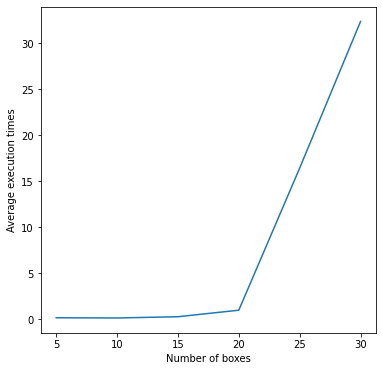

In [33]:
try:
    import matplotlib.pyplot as plt
    from pylab import rcParams
    %matplotlib inline
    rcParams['figure.figsize'] = 6, 6
    
    plt.plot(list(range(5, 31, 5)), avg_exec_time)
    plt.xlabel('Number of boxes')
    plt.ylabel('Average execution times')
    plt.show()
    
except ImportError:
    print("matplotlib not found, nothing will be displayed")
    plt = None
    def display_solution(sol):   pass


### Prob 2: Generalize the parttion

#### a (range of partition sizes)
Modify the partition method to have an argument i: gpart(i) where i = 0 is the version you originally created (i.e. partition fixed at the middle. For i larger than 0, Find the global optimal partition (smallest sum of partition crossing edges) where the partition sizes can vary as follows: $P1 = N//2-i,N//2-i+1,..,N//2+i-1,N//2+i$ and $P2 = N - P1$. This allows the partition algorithm to find better partitions over a range of sizes, but still with reasonable weights.

Run the sample above with i = 1 and 2 to see if the additional freedom can find a better parition. Then run some larger  random partition cases, where you re-run with larger values of i, measuring the run time. It should always be the case that wider allowed partitions find equivalent or lower cost cuts. What happens to the run time as i is increased?

#### b (range of sizes and weights)
Further modify the partition algorithm to add weights to the nets. Modify the random generator to create such weights uniformly over a preset range for testing and then modify the partition algorithm to minimize the weighted cut, retaining the allowed size variance above.

Test the sample below with i = 1,2,3 and be sure your solution runs for larger random cases.

In [34]:
########## Problem 2a ############

class Place1:
    
    def __init__(self, N, M, net):
        
        self.M = M
        self.N = N
        self.net = net
    
    def mk_uni_net(self, N):
        
        self.N = N
        box_ids = range(N)
        self.net = dict()
        
        t = list(range(1, N))
        connections_per_box = []
        for i in range(1,N+1):
            # choose any number of nets randomly per a box
            connections_per_box.append(random.choice(t))
        connection =0
        print("Connections per box", connections_per_box)
        # Distribute the nets uniformly
        for i in range(1,N+1):  # For each box
            choose_list = list(range(1, N+1))
            choose_list.remove(i)
            for j in range(0, connections_per_box[i-1]):  #  For each net per box
                
                connection = connection +1 
                box_select = random.choice(choose_list)
                choose_list.remove(box_select)  
                self.net[connection] = (i, box_select)                
           
        print("Total Connections: ", connection)
        
        self.M = connection
                
    def gpart(self, dev_range):
        
        cluster_nets = []
        
        for dev in range(dev_range+1):
            P1 = self.N // 2 + dev 
            P2  = self.N - P1 
            print("P2 is :", P2)
            # Binary selection variables for all N blocks: 0 => Group1, 1 => Group 2

            tm = Model(name = "Bipartion problem 2", ignore_names=True, checker='off')
            box_group = tm.binary_var_list(range(0, self.N), name='box_group')  # Box_ids are in order 0 to N-1
            print("Box group list is as follows: ", box_group)

            # Binary selection variables for all the edges: 0=> local edge, 1=> crossing

            edge_locality = tm.binary_var_list(range(0, self.M), name='edge_locality')
            # print(edge_locality) 

            ############## Constraints ##############

            # Randomly pick floor (N/2) boxes in group 1 and others in group 2
            # Exact P2 guys in Group 2
            tm.add_constraint(tm.sum(box_group[i] for i in range(0,self.N)) == P2)

            # Edge_locality is greater than the absolute difference between the cluster numbers of box [i][0] and box[i][1]
            for i in range (1,self.M+1):
                tm.add_constraint( tm.abs(box_group[self.net[i][0]-1] - box_group[self.net[i][1]-1]) <= edge_locality[i-1] )

            tm.minimize(tm.sum(edge_locality[i] for i in range (0,self.M)))

            tm.print_information()
            tm.parameters.timelimit = 100
            assert tm.solve(clean_before_solve = True, log_output=True), "!!! Solve of the model fails"
            tm.print_solution()
            
            cluster_nets.append(tm.objective_value)
            
        print("The cluster interconnect connections for increasing deviation is:", cluster_nets)
        print("The minimum is", min(cluster_nets))

In [35]:
N = 10 #number of boxes
M = 14 #number of nets

# I HAVE CHANGED THE NET ORDERING FROM 0th index to one-indexing

net = {1: (1,2), 2: (1,4), 3:(1,9), 4: (2,3), 5: (2,8), 6: (2,7), 7: (3,6), 8: (3,7), 9: (4,5), 10:(4,10), 11:(5,7),
      12: (6,7), 13: (6,8), 14: (8,10), 15: (9,10)}
net_weight = {1:2, 2:1, 3:3, 4:2, 5:1, 6:2, 7:1, 8:3, 9:1, 10:2, 11:4, 12:2, 13:4, 14:1}

In [36]:
Network1 = Place1(N, M, net)
print("Network1.N = ", Network1.N)
print("Network1.M = ", Network1.M)
print("Network1.net = ", Network1.net)

Network1.N =  10
Network1.M =  14
Network1.net =  {1: (1, 2), 2: (1, 4), 3: (1, 9), 4: (2, 3), 5: (2, 8), 6: (2, 7), 7: (3, 6), 8: (3, 7), 9: (4, 5), 10: (4, 10), 11: (5, 7), 12: (6, 7), 13: (6, 8), 14: (8, 10), 15: (9, 10)}


In [37]:
# parameter dev provides deviation from half partitioning of boxes
dev =5
Network1.gpart(dev)

P2 is : 5
Box group list is as follows:  [docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B)]
Model: Bipartion problem 2
 - number of variables: 80
   - binary=24, integer=0, continuous=56
 - number of constraints: 57
   - linear=57
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               100
Tried aggregator 2 times.
MIP Presolve eliminated 56 rows and 14 columns.
MIP Presolve added 70 rows and 14 columns.
Aggregator did 14 substitutions.
Reduced MIP has 57 rows, 66 columns, and 164 nonzeros.
Reduced MIP has 38 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.

In [38]:
avg_exec_time = []
dev = 5
runs = 1
for i in list(range(10, 26, 5)): # Increasing number of blocks per network
    sum_times = 0
    for j in range(runs): # Run each network 10 times for average
        Network1.mk_uni_net(i)
        start = time.perf_counter()
        Network1.gpart(dev)  
        exec_time = time.perf_counter() - start
        sum_times += exec_time
    avg_exec_time.append(sum_times/runs)

Connections per box [9, 5, 2, 4, 1, 6, 2, 2, 2, 5]
Total Connections:  38
P2 is : 5
Box group list is as follows:  [docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B)]
Model: Bipartion problem 2
 - number of variables: 200
   - binary=48, integer=0, continuous=152
 - number of constraints: 153
   - linear=153
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               100
Tried aggregator 2 times.
MIP Presolve eliminated 152 rows and 38 columns.
MIP Presolve added 190 rows and 38 columns.
Aggregator did 38 substitutions.
Reduced MIP has 153 rows, 162 columns, and 428 nonzeros.
Red

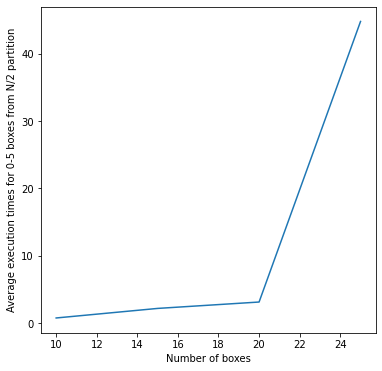

In [39]:
try:
    import matplotlib.pyplot as plt
    from pylab import rcParams
    %matplotlib inline
    rcParams['figure.figsize'] = 6, 6
    
    plt.plot(list(range(10, 26, 5)), avg_exec_time)
    plt.xlabel('Number of boxes')
    plt.ylabel('Average execution times for 0-5 boxes from N/2 partition')
    plt.show()
    
except ImportError:
    print("matplotlib not found, nothing will be displayed")
    plt = None
    def display_solution(sol):   pass


In [40]:
import numpy as np

In [41]:
########## Problem 2b ############

class Place1:
    
    def __init__(self, N, M, net, net_weight):
        
        self.M = M
        self.N = N
        self.net = net
        self.net_weight = net_weight
    
    def mk_uni_net(self, N):
        
        self.N = N
        box_ids = range(N)
        self.net = dict()
        self.net_weight = dict()
        
        t = list(range(1, N))
        a = list(range(1, 5)) #  Weights for different nets --> PRESET range (1 - 4)
        
        connections_per_box = []
        for i in range(1,N+1):
            # choose any number of nets randomly per a box
            connections_per_box.append(random.choice(t))
        connection =0
        print("Connections per box", connections_per_box)
        # Distribute the nets uniformly
        for i in range(1,N+1):  # For each box
            choose_list = list(range(1, N+1))
            choose_list.remove(i)
            for j in range(0, connections_per_box[i-1]):  #  For each net per box
                
                connection = connection +1 
                box_select = random.choice(choose_list)
                choose_list.remove(box_select)  
                self.net[connection] = (i, box_select)  
                self.net_weight[connection] = random.choice(a)
                
        print("Total Connections: ", connection)
        
        self.M = connection
                
    def gpart(self, dev_range):
        
        cluster_nets = []
        
        for dev in range(dev_range+1):
            P1 = self.N // 2 + dev 
            P2  = self.N - P1 
            print("P2 is :", P2)
            # Binary selection variables for all N blocks: 0 => Group1, 1 => Group 2

            tm = Model(name = "Bipartion problem 1", ignore_names=True, checker='off')
            box_group = tm.binary_var_list(range(0, self.N), name='box_group')  # Box_ids are in order 0 to N-1
            print("Box group list is as follows: ", box_group)

            # Binary selection variables for all the edges: 0=> local edge, 1=> crossing

            edge_locality = tm.binary_var_list(range(0, self.M), name='edge_locality')
            # print(edge_locality) 

            ############## Constraints ##############

            # Randomly pick floor (N/2) boxes in group 1 and others in group 2
            # Exact P2 guys in Group 2
            tm.add_constraint(tm.sum(box_group[i] for i in range(0,self.N)) == P2)

            # Edge_locality is greater than the absolute difference between the cluster numbers of box [i][0] and box[i][1]
            for i in range (1,self.M+1):
                tm.add_constraint( tm.abs(box_group[self.net[i][0]-1] - box_group[self.net[i][1]-1]) <= edge_locality[i-1] )

            tm.minimize(tm.sum((edge_locality[i])*(self.net_weight[i+1]) for i in range (0,self.M)))

            tm.print_information()
            tm.parameters.timelimit = 100
            assert tm.solve(clean_before_solve = True, log_output=True), "!!! Solve of the model fails"
            tm.print_solution()
            
            cluster_nets.append(tm.objective_value)
            
        print("Minimum global_cuts for increasing deviation is:", cluster_nets)
        print("The minimum is", min(cluster_nets))

In [42]:
Network1 = Place1(N, M, net, net_weight)
print("Network1.N = ", Network1.N)
print("Network1.M = ", Network1.M)
print("Network1.net = ", Network1.net)
print("Network1.net_weight = ", Network1.net_weight)
dev = 2
Network1.gpart(dev)

Network1.N =  10
Network1.M =  14
Network1.net =  {1: (1, 2), 2: (1, 4), 3: (1, 9), 4: (2, 3), 5: (2, 8), 6: (2, 7), 7: (3, 6), 8: (3, 7), 9: (4, 5), 10: (4, 10), 11: (5, 7), 12: (6, 7), 13: (6, 8), 14: (8, 10), 15: (9, 10)}
Network1.net_weight =  {1: 2, 2: 1, 3: 3, 4: 2, 5: 1, 6: 2, 7: 1, 8: 3, 9: 1, 10: 2, 11: 4, 12: 2, 13: 4, 14: 1}
P2 is : 5
Box group list is as follows:  [docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B)]
Model: Bipartion problem 1
 - number of variables: 80
   - binary=24, integer=0, continuous=56
 - number of constraints: 57
   - linear=57
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPA

In [43]:
Network1.mk_uni_net(N)
print("Network1.N = ", Network1.N)
print("Network1.M = ", Network1.M)
print("Network1.net = ", Network1.net)
print("Network1.net_weight = ", Network1.net_weight)

Connections per box [7, 9, 1, 1, 3, 1, 2, 2, 7, 1]
Total Connections:  34
Network1.N =  10
Network1.M =  34
Network1.net =  {1: (1, 8), 2: (1, 10), 3: (1, 2), 4: (1, 5), 5: (1, 6), 6: (1, 3), 7: (1, 9), 8: (2, 5), 9: (2, 4), 10: (2, 3), 11: (2, 10), 12: (2, 7), 13: (2, 8), 14: (2, 1), 15: (2, 6), 16: (2, 9), 17: (3, 5), 18: (4, 2), 19: (5, 3), 20: (5, 8), 21: (5, 7), 22: (6, 8), 23: (7, 1), 24: (7, 5), 25: (8, 3), 26: (8, 1), 27: (9, 6), 28: (9, 7), 29: (9, 3), 30: (9, 8), 31: (9, 1), 32: (9, 4), 33: (9, 5), 34: (10, 6)}
Network1.net_weight =  {1: 4, 2: 4, 3: 2, 4: 3, 5: 4, 6: 3, 7: 1, 8: 4, 9: 2, 10: 1, 11: 4, 12: 3, 13: 3, 14: 4, 15: 1, 16: 2, 17: 2, 18: 4, 19: 2, 20: 3, 21: 2, 22: 1, 23: 2, 24: 4, 25: 2, 26: 2, 27: 4, 28: 4, 29: 1, 30: 1, 31: 2, 32: 1, 33: 4, 34: 4}


In [44]:
dev = 2
Network1.gpart(dev)

P2 is : 5
Box group list is as follows:  [docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B), docplex.mp.Var(type=B)]
Model: Bipartion problem 1
 - number of variables: 180
   - binary=44, integer=0, continuous=136
 - number of constraints: 137
   - linear=137
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               100
Tried aggregator 2 times.
MIP Presolve eliminated 136 rows and 34 columns.
MIP Presolve added 170 rows and 34 columns.
Aggregator did 34 substitutions.
Reduced MIP has 137 rows, 146 columns, and 384 nonzeros.
Reduced MIP has 78 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve t

In [45]:
''' 
 Uncomment for performance analysis
'''
# avg_exec_time = []
# dev = 5
# runs = 1
# for i in list(range(10, 26, 5)): # Increasing number of blocks per network
#    sum_times = 0
#    for j in range(runs): # Run each network 10 times for average
#        Network1.mk_uni_net(i)
#        start = time.perf_counter()
#        Network1.gpart(dev)  
#        exec_time = time.perf_counter() - start
#        sum_times += exec_time
#    avg_exec_time.append(sum_times/runs)


' \n Uncomment for performance analysis\n'

### Prob 3: Placement by Recursive Bi-partition
Here, we re-visit the problem of linear placement, for larger examples of uniform sized boxes.

The general strategy is to efficiently partition the graph into small sub-problems connected by minimal cuts to a size that can be efficiently solved by the exact solver you already have. (You get to tune the size and flexibility of the partitions and the size to use the exact partition). Then you assemble the netlist, with positions from the previous scale solutions. Note that you can invoke your exact partitioner to make increment improvements fixed or warm restarts.

In a fixed restart, you set additional constraints based on your previous solved problems and run the solver with those  constraints. (e.g. you could have the solver re-order the elements within position boundaries set by the partitions).

In a warm restart you use the following sequence:
```
    warmstart=mdl.new_solution()
    warmstart.add_var_value(values...)
    warmstart.add_var_value(more values...)
    mdl.add_mip_start(warmstart)
    mdl.solve()
```
then solve as usual. The trial solution need not be a feasible one. The fixed-start case runs a substantially reduced problem while the warm start just starts from the solution points you recommend. In neither case is your exact algorithm likely to find optimality unless you are very restrictive in the fixed start, so it makes sense to run for a limited period of time to make use of cplex incremental improvements.

Using your placer, run linear placements for 10 and 15 elements checking against your optimal answers. For 50, 100, 150, 200, ... compare your results with those from early integer results of the exact algorithm when found in less than 200 sec. Plot the runtime trend of your heuristic.

Since you have multiple options here, please don't go crazy with tuning once you have a working algorithm as you can spend enormous time doing so.

For verification, run the weighted sample above as a linear placement. (Plot the result for this case).

In [12]:
from collections import OrderedDict

In [30]:
########## Problem 3 ############

class Place1:
    
    def __init__(self, N, M, net, net_weight):
        
        self.M = M
        self.N = N
        self.net = net
        self.net_weight = net_weight
    
    def mk_uni_net(self, N):
        
        self.N = N
        box_ids = range(N)
        self.net = OrderedDict()
        self.net_weight = OrderedDict()
        
        t = list(range(1, N))
      #  a = list(range(1, 5)) #  Weights for different nets --> PRESET range (1 - 4)
        
        connections_per_box = []
        for i in range(1,N+1):
            # choose any number of nets randomly per a box
            connections_per_box.append(random.choice(t))
        connection =0
        print("Connections per box", connections_per_box)
        # Distribute the nets uniformly
        for i in range(1,N+1):  # For each box
            choose_list = list(range(1, N+1))
            choose_list.remove(i)
            for j in range(0, connections_per_box[i-1]):  #  For each net per box
                
                connection = connection +1 
                box_select = random.choice(choose_list)
                choose_list.remove(box_select)  
                self.net[connection] = (i, box_select)  
                self.net_weight[connection] = 1
                
        print("Total Connections: ", connection)
        self.M = connection
        return self.M, self.net, self.net_weight
                
    def gpart(self, N, M, box_list, net):
        
        
        print (" ########################  NEW GPART ACCESS ####################### ");
        
        net_keys = list(net.keys())
        print("Net keys are: ", net_keys)
        
        box_indices = list(range(0,N))  
        
        M =len(net)
        dev_max = N // 4
        if (N<=2): # Stop partitioning if there are only 2 elements.
            print("Base Cases Reached!!! ")
            return box_list
        else:           
            # if (N==3):
            #     dev_factor = 0   # IMPORTANT SO THAT WE DON'T GET 0 CUTS ON N/4, 3N/4  partitions
            
            cluster_nets = []
            box_locations_list = []
            net_locality_list = []   
            for dev in range(dev_max+1):
                 
                print(" -------------- DEV FACTOR IS", dev, "------------")    

                P1 = N // 2 - dev  
                P2  = N - P1 
                print("P2 is :", P2)
                # Binary selection variables for all N blocks: 0 => Group1, 1 => Group 2

                tm = Model(name = "Linear placement problem 3", ignore_names=True, checker='off')
                box_group = tm.binary_var_list(range(0, N), name='box_group')  # Box_ids are in order 0 to N-1
                # print("Box group list is as follows: ", box_group)

                # Binary selection variables for all the edges: 0=> local edge, 1=> crossing

                edge_locality = tm.binary_var_list(range(0, M), name='edge_locality')
                # print(edge_locality) 

                ############## Constraints ##############

                # Randomly pick floor (N/2) boxes in group 1 and others in group 2
                # Exact P2 guys in Group 2
                tm.add_constraint(tm.sum(box_group[i] for i in range(0,N)) == P2)

                # Edge_locality is greater than the absolute difference between the cluster numbers of box [i][0] and box[i][1]
                for i in range(0,M):
                    tm.add_constraint( tm.abs(box_group[box_list.index(net[net_keys[i]][0])] \
                                    - box_group[box_list.index(net[net_keys[i]][1])]) <= edge_locality[i] )

                tm.minimize(tm.sum((edge_locality[i])*(net_weight[i+1]) for i in range (0,M)))

                tm.print_information()
                tm.parameters.timelimit = 200
                assert tm.solve(clean_before_solve = True, log_output=True), "!!! Solve of the model fails"
                tm.print_solution()

                cluster_nets.append(tm.objective_value)
                
                box_locations = tm.solution.get_values(box_group)
                # print("Box locations among the 2 clusters are:", box_locations)
                box_locations_list.append(box_locations)
            
                net_locality = tm.solution.get_values(edge_locality)
                # print("Nets local or global (intercluster connection):", net_locality)
                net_locality_list.append(net_locality)
                
            print("Minimum global_cuts for increasing deviation is:", cluster_nets) 
            print("The minimum is", min(cluster_nets))

        # At each recursion: 2 types of nets: local for 2 sub networks and global inter cluster nets      
        # Access the solution
        print(box_locations_list)

        # choose the split with largest descent in crossings
        diff_list = list(np.diff(cluster_nets))
        print(diff_list)
        
        best_dev_factor = 0
        if diff_list:
            best_dev_factor = diff_list.index(min(diff_list))+1 
        print("Selected_dev_Factor for the current iteration is: ", best_dev_factor)    
        print("Corresponding boxes are :", box_locations_list[best_dev_factor-1])
        print("Corresponding net localities are :", net_locality_list[best_dev_factor-1])
        
        # Get the minimum cluster index and partition recursively 
        
        cluster1 = []
        cluster2 = []
        index =0
        for value in box_locations_list[best_dev_factor-1]:
            if value == 0:
                cluster1.append(box_list[index])
            else:
                cluster2.append(box_list[index])
            index += 1
        print("Cluster 1 is", cluster1)
        print("Cluster 2 is", cluster2)
        
        local_nets_g1 = OrderedDict()
        local_nets_g2 = OrderedDict()
        global_nets = OrderedDict()
        index =0
        for value in net_locality_list[best_dev_factor-1]:

            if value == 0:
                if net[net_keys[index]][0] in cluster1: 
                    local_nets_g1[net_keys[index]] = net[net_keys[index]]
                else:
                    local_nets_g2[net_keys[index]] = net[net_keys[index]]
            else:
                global_nets[net_keys[index]] = net[net_keys[index]]
            index += 1     
            
        print("Local nets for group1 are", local_nets_g1 )
        print("Local nets for group2 are", local_nets_g2 )
        print("Global nets are", global_nets)
        
        # Apply recursion on group1 and group 2
        list1 = self.gpart(len(cluster1), len(local_nets_g1), cluster1, local_nets_g1)
        list2 = self.gpart(len(cluster2), len(local_nets_g2), cluster2, local_nets_g2)
         
        # After recursive partitioning, decide on the relative placement of the cluster based on global nets
        
        optimized_box_list = list1 + list2
        
        box_locations.clear()   # Clear the var list before the next iteration
        net_locality.clear()    # Clear the var list before the next iteration
        
        return optimized_box_list

In [31]:
N = 20
box_list = list(range(1,N+1))
print("Box_list is :", box_list)
net.clear()
print("net is clear: ", net)
net_weight = OrderedDict()
net_weight.clear()
print("net weight is clear: ", net)
net = OrderedDict()
Network2 = Place1(N, M, net, net_weight)
M, net, net_weight = Network2.mk_uni_net(N)
print("Network2.N = ", Network2.N)
print("Network2.M = ", Network2.M)
print("Network2.net = ", Network2.net)
print("Network2.net_weight = ", Network2.net_weight)


Box_list is : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
net is clear:  OrderedDict()
net weight is clear:  OrderedDict()
Connections per box [16, 3, 8, 14, 1, 5, 18, 16, 16, 5, 1, 14, 1, 10, 11, 1, 1, 10, 2, 5]
Total Connections:  158
Network2.N =  20
Network2.M =  158
Network2.net =  OrderedDict([(1, (1, 2)), (2, (1, 13)), (3, (1, 12)), (4, (1, 19)), (5, (1, 8)), (6, (1, 18)), (7, (1, 16)), (8, (1, 11)), (9, (1, 5)), (10, (1, 7)), (11, (1, 3)), (12, (1, 9)), (13, (1, 17)), (14, (1, 15)), (15, (1, 4)), (16, (1, 20)), (17, (2, 10)), (18, (2, 14)), (19, (2, 15)), (20, (3, 2)), (21, (3, 8)), (22, (3, 11)), (23, (3, 13)), (24, (3, 18)), (25, (3, 19)), (26, (3, 16)), (27, (3, 20)), (28, (4, 9)), (29, (4, 17)), (30, (4, 8)), (31, (4, 16)), (32, (4, 20)), (33, (4, 13)), (34, (4, 2)), (35, (4, 10)), (36, (4, 7)), (37, (4, 18)), (38, (4, 14)), (39, (4, 12)), (40, (4, 6)), (41, (4, 19)), (42, (5, 8)), (43, (6, 13)), (44, (6, 1)), (45, (6, 4)), (46, (6, 3)), (47, (6,

In [32]:
# Hyperparameter : deviation range --> using N/4
# Partitions tried: N/ 2-- N/4 for a given N
# max_dev = N // 4
Optimized_box_list = []
Optimized_box_list = Network2.gpart(N, M, box_list, net)


 ########################  NEW GPART ACCESS ####################### 
Net keys are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158]
 -------------- DEV FACTOR IS 0 ------------
P2 is : 10
Model: Linear placement problem 3
 - number of variables: 810
   - binary=178, integer=0, continuous=632
 - number of constraints: 633
   - linear=633
 - parameters: defaults
 -

In [33]:
print("The Optimized arrangement of boxes by recursive partitioning is:", Optimized_box_list )

[17, 13, 19, 11, 3, 16, 5, 20, 1, 2, 15, 9, 10, 12, 4, 8, 18, 6, 7, 14]

In [39]:
''' 
 Uncomment for performance analysis
'''
avg_exec_time = []
max_boxes = 40

M = 20 # value doesn't matter - new assignments every iteration below
runs = 1
for N in list(range(10, max_boxes+1, 5)): # Increasing number of blocks per network
    sum_times = 0
    for j in range(runs): # Run each network 10 times for average   --- NO!! - 2 times is good
        
        box_list = list(range(1,N+1))
        print("Box_list is :", box_list)
        net.clear()
        print("net is clear: ", net)
        net_weight = OrderedDict()
        net_weight.clear()
        print("net weight is clear: ", net)
        net = OrderedDict()
        Network2 = Place1(N, M, net, net_weight)
        M, net, net_weight = Network2.mk_uni_net(N)
        
        start = time.perf_counter()
        Optimized_box_list = []
        Optimized_box_list = Network2.gpart(N, M, box_list, net)  
        exec_time = time.process_time() - start
        sum_times += exec_time
    avg_exec_time.append(sum_times/runs)
    



Box_list is : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
net is clear:  OrderedDict()
net weight is clear:  OrderedDict()
Connections per box [5, 8, 1, 2, 5, 8, 6, 6, 4, 4]
Total Connections:  49
 ########################  NEW GPART ACCESS ####################### 
Net keys are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
 -------------- DEV FACTOR IS 0 ------------
P2 is : 5
Model: Linear placement problem 3
 - number of variables: 255
   - binary=59, integer=0, continuous=196
 - number of constraints: 197
   - linear=197
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               200
Tried aggregator 2 times.
MIP Presolve eliminated

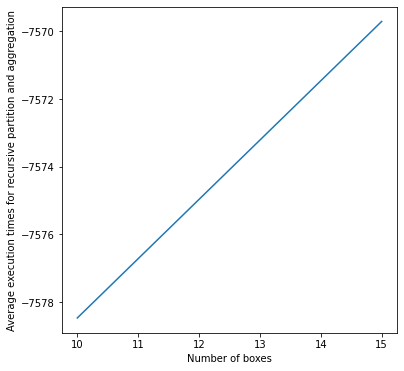

In [40]:
try:
    import matplotlib.pyplot as plt
    from pylab import rcParams
    %matplotlib inline
    rcParams['figure.figsize'] = 6, 6
    
    plt.plot(list(range(10, max_boxes+1, 5)), avg_exec_time)
    plt.xlabel('Number of boxes')
    plt.ylabel('Average execution times for recursive partition and aggregation')
    plt.show()
    
except ImportError:
    print("matplotlib not found, nothing will be displayed")
    plt = None
    def display_solution(sol):   pass
